In [1]:
from scipy import interpolate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skmisc import loess
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from scipy.linalg import svd 

In [2]:
# By:
# Olek Yardas [oyardas2]: coding and plotting
# Dreycen Foiles [dfoiles2]: coding and plotting

Olek was the coder for parts 1 and 2, while Dreycen was the planner. Conversely, Olek was the planner for part 3 and Dreycen was the coder. 

In [3]:
df = pd.read_csv('Coding3_Data.csv')

In [4]:
def smoother_diags(x, span):
    n = len(x)
    lev = np.zeros(n)
    for i in range(0, n):
        y = np.zeros(n)
        y[i] = 1
        loess_mod = loess.loess(x, y, span=span)
        loess_mod.fit()
        yi = loess_mod.outputs.fitted_values
        #_, yi, _ = loess_1d.loess_1d(x, y, degree=2, frac=span)
        #yi = interpolate.UnivariateSpline(x, y, s=span)(x)
        lev[i] = yi[i]
    return lev

In [5]:
def onestep_CV(x, y, span):
    n = len(x)
    loess_mod = loess.loess(x, y, span=span)
    loess_mod.fit()
    yhat = loess_mod.outputs.fitted_values
    r = y - yhat
    Slam_diags = smoother_diags(x, span)
    cv = (r / (1 - Slam_diags))**2
    #for i, s in enumerate(Slam_diags):
    #    cv.append((r[i] / (1 - s))**2)
    
    d = 1 - (np.sum(Slam_diags) / n)
    gcv = (r / d)**2
    
    return (np.mean(cv), np.mean(gcv))
    
   

In [6]:
def loocv(x, y, spans):
    m = len(spans)
    cv = np.zeros(m)
    gcv = np.zeros(m)
    
    for i in range(0, m):
        cv[i], gcv[i] = onestep_CV(x, y, spans[i])
        #cv[i] = tmp[0]
        #gcv[i] = tmp[1]
    return (cv, gcv)
    
    

In [7]:
spans = np.linspace(0.20, 0.90, 30)
cv, gcv = loocv(df['x'].values, df['y'].values, spans)

In [8]:
print(f"CV: {cv}")
best_idx = np.where(cv == np.min(cv))[0][0]
print(f"Optimum span for CV: {spans[best_idx]}")
print(f"GCV: {gcv}")
best_idx = np.where(gcv == np.min(gcv))[0][0]
print(f"Optimum span for GCV: {spans[best_idx]}")

CV: [12.4159107  12.4159107   2.2414735   1.53747419  1.53747419  1.50297981
  1.25917471  1.20462627  1.20462627  1.19037993  1.15681212  1.15681212
  1.13444224  1.12430566  1.17966375  1.17966375  1.18490225  1.17946416
  1.25091383  1.25091383  1.5135015   1.55356226  1.55356226  1.63617462
  1.69044635  1.76453363  1.76453363  1.97609351  2.01306392  2.03510792]
Optimum span for CV: 0.5137931034482759
GCV: [2.11016184 2.11016184 1.48920563 1.2460115  1.2460115  1.19010984
 1.17442296 1.13004199 1.13004199 1.1025399  1.06250346 1.06250346
 1.04913674 1.04042227 1.11884055 1.11884055 1.12286084 1.11926881
 1.18058478 1.18058478 1.46264622 1.51909081 1.51909081 1.62742935
 1.67437117 1.74454909 1.74454909 1.92569596 1.95871957 1.9798204 ]
Optimum span for GCV: 0.5137931034482759


In [9]:
loess_mod = loess.loess(df['x'],df['y'],span=.5)
loess_mod.fit() 
new_x = np.linspace(.01,.9,100)
new_y = loess_mod.predict(new_x)

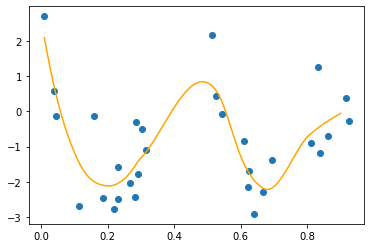

In [10]:
plt.scatter(df['x'], df['y'])
plt.plot(new_x,new_y.values,color='orange')

## Part 2

In [11]:
from sklearn.preprocessing import SplineTransformer
from sklearn.cluster import KMeans

In [12]:
RANDOM_SEED=7568

In [13]:
df = pd.read_csv('Sales_Transactions_Dataset_Weekly.csv')
data = df.loc[:, 'W0':'W51']
cdf = (data.T - data.mean(axis=1)).T
X = cdf.values

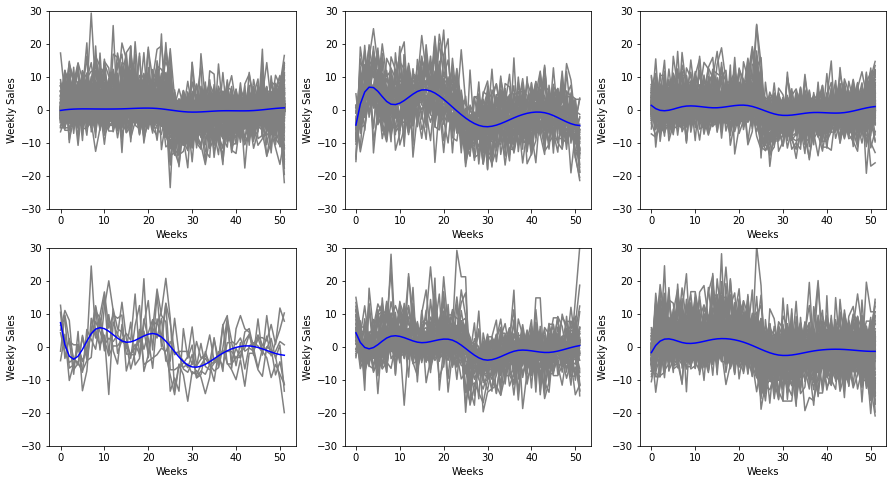

In [14]:
X = cdf.to_numpy()
X = X - np.mean(X, axis=1).reshape(-1,1)
x = np.arange(1,53,1).reshape(-1,1)
y = cdf['W0'].to_numpy().reshape(-1,1)
s = SplineTransformer(n_knots=8, degree=3, include_bias=False)
F = s.fit_transform(x, y)
B = (np.linalg.inv(F.T@F)@F.T@X.T).T

# B-fitted k-means
C = KMeans(n_clusters=6, random_state=RANDOM_SEED)
cluster_idx = C.fit_predict(B)
# Time series are columns of cluster_ts
cluster_ts = F@C.cluster_centers_.T

fig, ax = plt.subplots(2,3, figsize=(15,8))
for i in range(0, np.shape(cluster_ts)[1]):
    axi = ax.flatten()[i]
    cluster_idx_i = np.where(cluster_idx == i)[0]
    for j in cluster_idx_i:
        axi.plot(X[j,:], color='gray')
    axi.plot(cluster_ts[:,i] - np.mean(cluster_ts[:,i]), color='blue')
    axi.set_ylim(-30, 30)
    axi.set_ylabel('Weekly Sales')
    axi.set_xlabel('Weeks')

    

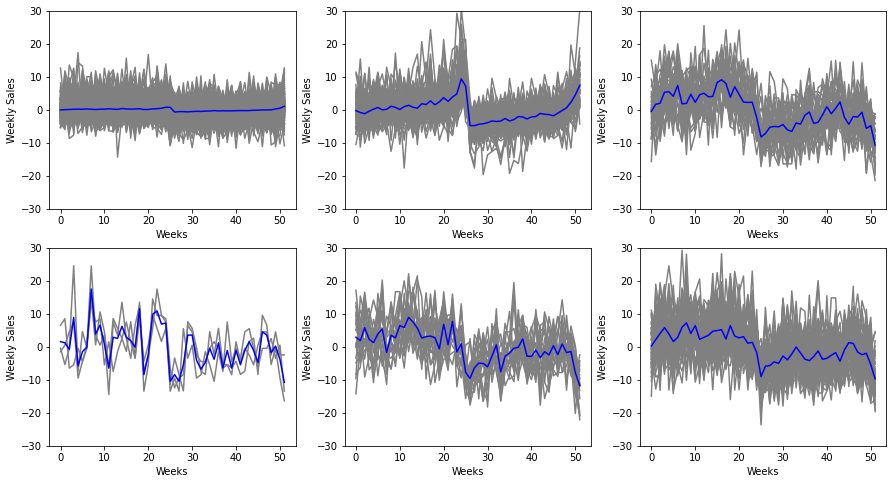

In [15]:
# X-fitted k-means
C = KMeans(n_clusters=6, random_state=RANDOM_SEED)
cluster_idx = C.fit_predict(X)
# Time series are columns of cluster_ts

fig, ax = plt.subplots(2,3, figsize=(15,8))
for i in range(len(C.cluster_centers_)):
    axi = ax.flatten()[i]
    cluster_idx_i = np.where(cluster_idx == i)[0]
    for j in cluster_idx_i:
        axi.plot(X[j,:], color='gray')

    centered_time_series = C.cluster_centers_[i]
    
    axi.plot(centered_time_series, color='blue')
    axi.set_ylim(-30, 30)
    axi.set_ylabel('Weekly Sales')
    axi.set_xlabel('Weeks')

    

# Part 3

We use SVD to perform linear regression on data sets that have lots of colinearity. We use the ridgeless regression technique by first centering input training data and centering test data using the mean of the **training** data columns. We then perform SVD on the centered training data and established a tolerance. Any values in the $V_h$ matrix that is below his tolerance is disguarded. We then multiply the training data by $V_h^T$ to calculate the design matrix $F_{train}$. We can then exploit the orthogonality of the $U$ and $D$ matrices to calculate the least squares coefficients as 
$$\alpha = F_{train}^T y_{train}/ \sum_j F_{train,j}^2$$ 
where $\sum_j F_{train,j}^2$ is the column sum squared of $F_{train}$. We can then calculate the y-intercept $b_0$. Given by $b_0 = \langle y_{train} \rangle$. We then calculate our prediction as 
$$y_{pred} = x_{test} \alpha + b_0 $$
We can then calculate the mean squared error 
$$ MSE = \langle (y_{test} - y_{pred})^2 \rangle $$

In [16]:
df = pd.read_csv("https://liangfgithub.github.io/F22/Coding3_dataH.csv")
X = df.values 

In [17]:
def ridgeless(train, test, n_features):

    eps = 1e-10

    xtrain = train[:, 1:]
    ytrain = train[:, 0]

    xtest = test[:, 1:]
    ytest = test[:, 0]

    xtrain -= np.mean(xtrain, axis=0)
    xtest -= np.mean(xtrain, axis=0)

    U, D, Vh = svd(xtrain)

    k = np.sum(D > eps)

    F_train = xtrain @ Vh.T[:,:k] 
    F_test = xtest @ Vh.T[:,:k]

    coefs = F_train.T @ ytrain / np.sum(F_train**2,axis=0)

    b0 = np.mean(ytrain)

    preds = F_test[:,:n_features] @ coefs[:n_features] + b0
    return np.mean((ytest-preds)**2)


In [18]:

num_folds = 30
feature_range = np.arange(5,240)

comp_error = [] 


for n_features in feature_range:

    cverror = [] 

    for fold in range(num_folds):

        fold_train,fold_test = train_test_split(X, test_size=.75)        
        cverror.append(ridgeless(fold_train,fold_test, n_features))

    comp_error.append(np.median(np.array(cverror)))        

    

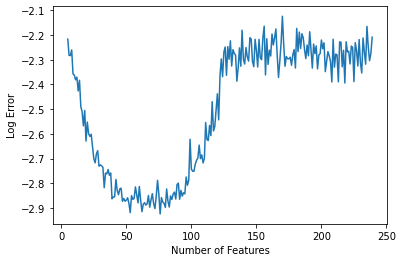

In [19]:
plt.plot(feature_range, np.log(comp_error))
plt.xlabel("Number of Features")
plt.ylabel("Log Error")
plt.show() 